Rafał Gołębiowski

# Klasteryzacja irysów

## Wczytać dane iris oraz rozdzielić je na cześć wejściową (X) i decyzje (d).

In [1]:
import scipy
import sklearn
import numpy as np
from sklearn import datasets
from sklearn.cluster import AgglomerativeClustering 
from sklearn.cluster import KMeans 
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from scipy.spatial import ConvexHull
from sklearn.metrics import jaccard_score
import pandas as pd
import warnings
warnings.filterwarnings("ignore")


iris = datasets.load_iris()

X = iris['data']
d = iris['target']

## Wykonać grupowanie danych X używając hierarchicznych metod aglomeracji.

In [2]:
agglomeratives = [AgglomerativeClustering(linkage="single", n_clusters=3),
                AgglomerativeClustering(linkage="average", n_clusters=3),
                AgglomerativeClustering(linkage="complete", n_clusters=3),
                AgglomerativeClustering(linkage="ward", n_clusters=3)]
for agglomerative in agglomeratives:
    agglomerative.fit(X)

## Powtórzyć wynik dla metody KMeans oraz DBSCAN

In [3]:
kMeans = KMeans(3)
kMeans.fit(X)

dbscan = DBSCAN(eps=0.8, min_samples=2)
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=0.8, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=2, n_jobs=None, p=None)

## Porównać indeks Jaccarda danych pogrupowanych względem znanej klasy decyzyjnej.

In [4]:
titles = [f'AgglomerativeClustering(linkage={agglomerative.linkage})' for agglomerative in agglomeratives]
titles.append('kMeans')
titles.append('dbscan')
jaccardDf = pd.DataFrame(columns=["Clustering", "JaccardScore", "JaccardManual"])
for k, clustering in enumerate([*agglomeratives, kMeans, dbscan]):
    tmp = confusion_matrix(d, clustering.labels_)
    jaccardDf.loc[k] = [titles[k],
                        jaccard_score(d, clustering.labels_, average = "micro"), 
                        np.sum(np.max(tmp, axis = 1))/np.sum(tmp)]
print(jaccardDf)

                                  Clustering  JaccardScore  JaccardManual
0    AgglomerativeClustering(linkage=single)      0.006711       0.986667
1   AgglomerativeClustering(linkage=average)      0.136364       0.906667
2  AgglomerativeClustering(linkage=complete)      0.003344       0.840000
3      AgglomerativeClustering(linkage=ward)      0.132075       0.893333
4                                     kMeans      0.136364       0.893333
5                                     dbscan      0.515152       0.986667


Funkcja jaccard_score daje małe, nieprawidłowe wyniki, dlatego że bierze pod uwagę jedynie numer etykiety. Numery etykiet zwracane przez algorytmy mogą być inne, mimo tego że reprezentują tą samą grupę punktów, np. pewnej grupie algorytm kMeans nadał etykietę 1, a w oryginalnych danych te próbki miały etykietę 0.
Ręczne policzenie indeksu Jaccarda również daje błędne wyniki, ponieważ zakłada, że większość próbek będzie w odpowiednich grupach. Z tego powodu wyniki AgglomerativeClustering(linkage=single) i dbscan dają wysokie, jednak nieprawidłowe wyniki.
Gdy weźmiemy to pod uwagę, najlepszymi metodami okażą się AgglomerativeClustering(linkage=average), AgglomerativeClustering(linkage=ward), kMeans z około 90% skutecznością.

## Zwizualizować dane rzutujac je na dwie pierwsze składowe główne, klasy otoczyć powłoka wypukłą (scipy.spatial.ConvexHull).

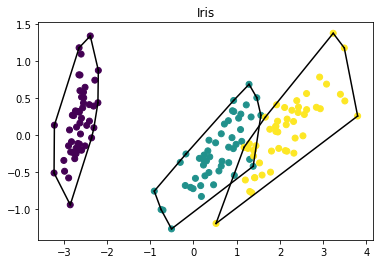

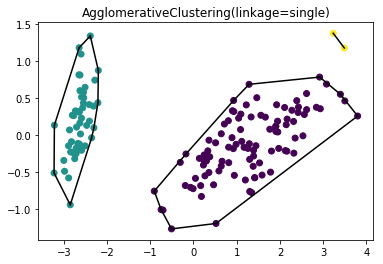

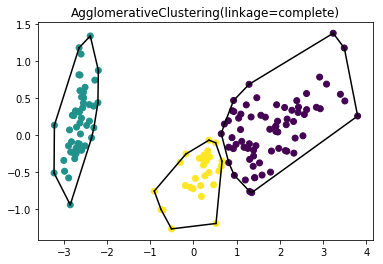

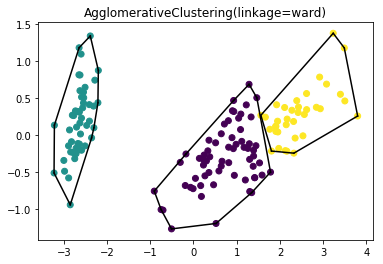

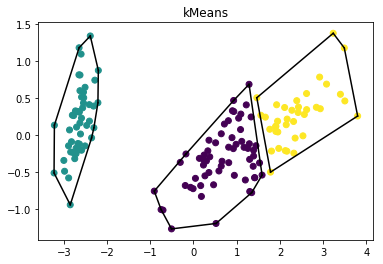

In [5]:
XPca = PCA(n_components=2).fit_transform(X)
plt.scatter(XPca[:, 0], XPca[:, 1], c = d) 
plt.title("Iris")

for i in range(3):
    XHull = XPca[d == i, :]
    hull = ConvexHull(XHull)
    for simplex in hull.simplices:
        plt.plot(XHull[simplex, 0], XHull[simplex, 1], 'k-')
plt.show()

for k, clustering in enumerate([*agglomeratives, kMeans, dbscan]):
    plt.scatter(XPca[:, 0], XPca[:, 1], c = clustering.labels_) 
    plt.title(titles[k])

    for i in range(3):
        XHull = XPca[clustering.labels_ == i, :]
        if(XHull.shape[0] > 2):
            hull = ConvexHull(XHull)
            for simplex in hull.simplices:
                plt.plot(XHull[simplex, 0], XHull[simplex, 1], 'k-')
        elif(XHull.shape[0] == 2):
            plt.plot(XHull[:, 0], XHull[:, 1], 'k-')

    plt.show()

# Kwantowanie wektorowe

## Wczytać dowlony obraz np.: w rozmiarze 640 × 480 × 3

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.measure import compare_ssim as ssim
from skimage import io
from skimage import data, img_as_float

img  = io.imread('img2.jpeg')

## Przekształcić (zwektoryzować) obraz do rozmiaru 640 · 480 × 3

In [7]:
imgReshaped = img.reshape((img.shape[0] * img.shape[1], img.shape[2]))

## Podzielić próbki na kolejno 2,3,5,10,30 i 100 skupień

## Wykonać na danych kwantowanie wektorowe zastępując wszystkie próbki ze skupienia punktem centralnym.

## Dokonać przekształcenia odwrotnego danych skwantowanych do przestrzeni oryginalnej 640 × 480 × 3.

## Zwizualizować oba obrazy przed i po kwantyzacji dla różnej liczby skupień.


## W każdym przypadku wyznaczyć błąd kwantyzacji.

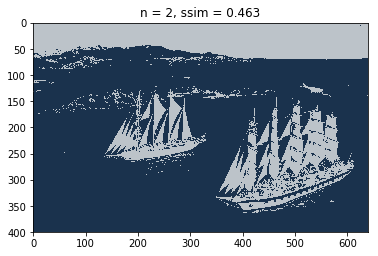

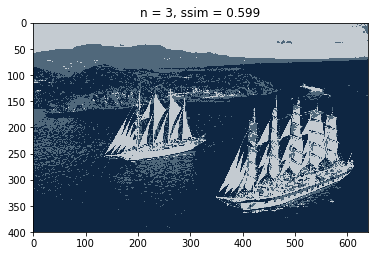

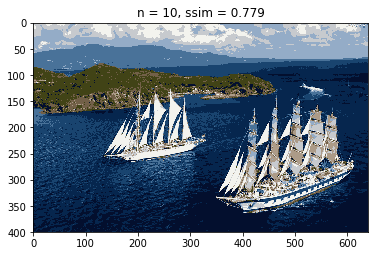

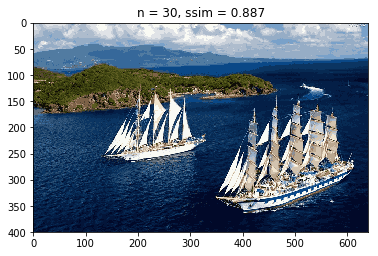

In [8]:
numberOfCenters = [2, 3, 5, 10, 30, 100, 1000]

plt.imshow(img)
plt.title("Original image")
plt.show()

for i, n in enumerate(numberOfCenters):
    kMeans = KMeans(n, n_init=1)
    kMeans.fit(imgReshaped)
    
    imgKMeans = kMeans.cluster_centers_[kMeans.labels_].astype(int)

    imgKMeans = imgKMeans.reshape((img.shape[0], img.shape[1], img.shape[2]))

    ssim_const = ssim(img, imgKMeans, multichannel=True)
    plt.title(f'n = {n}, ssim = {ssim(img, imgKMeans, multichannel=True):.3f}')
    plt.imshow(imgKMeans)
    plt.show()

Dla 30 klastrów uzyskujemy 89% zgodności z oryginalnym obrazem. Obraz wygląda całkiem dobrze, jednak nadal widać różnicę względem obrazu oryginalnego. Im więcej klastrów tym różnice stają się mniejsze i dla 1000 klastrów uzyskujemy 99% podobieństwa. Algorytm kMeans może zostać wykorzystany jako sposób kompresji, jednak trzeba pamiętać, że zredukuje on ilość kolorów w obrazie do ilości klastrów. W związku z tym obrazy z duża ilością kolorów uzyskają niższy stopień podobieństwa.